In [563]:
import pint
si = pint.UnitRegistry()

In [564]:
from matplotlib import pyplot
si.setup_matplotlib()

In [565]:
%run mpdata.ipynb

In [566]:
%run coord.ipynb

In [567]:
def plot_init():
    pyplot.grid()
    
def plot_step(r, psi, t):
    pyplot.step(mpdata.r, mpdata.psi, linestyle='--', where='mid', label=str(t))

In [583]:
nr = 32
nt = 12
dt = 1 * si.second
r_min = 10 * si.micrometre
r_max = 100 * si.micrometre
r_mid = r_min + .2*(r_max - r_min) 
psi0 = lambda r: 1 / ((r-r_mid)**2 + 1 * r_mid.units**2)

drdt = lambda r: 0.25 * si.micrometre / si.second

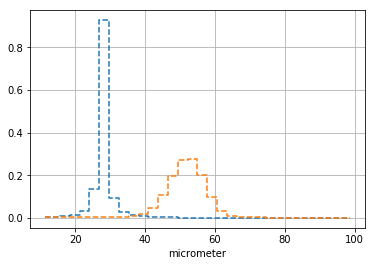

In [584]:
mpdata = MPDATA(nr, r_min, r_max, dt, psi0, x_id(si))

plot_init()
plot_step(mpdata.r, mpdata.psi, 0)

for t in range(nt): 
    mpdata.step(drdt)
plot_step(mpdata.r, mpdata.psi, t+1)

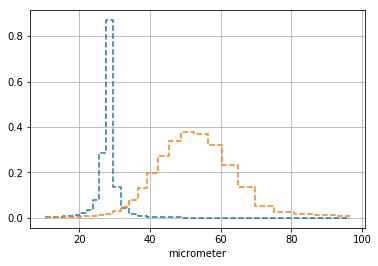

In [585]:
mpdata = MPDATA(nr, r_min, r_max, dt, psi0, x_ln(si))

plot_init()
plot_step(mpdata.r, mpdata.psi, 0)

for t in range(nt): 
    mpdata.step(drdt)
plot_step(mpdata.r, mpdata.psi, t+1)